# **Import Libraries**

In [30]:

#other 
import string
import numpy as np
import random
import pandas as pd
from datetime import datetime
from string import punctuation
import matplotlib.pyplot as plt 
import re 
import matplotlib.dates as mdates

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

#sklearn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [31]:
nltk.download("stopwords") 
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **Import Data**

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataframe= pd.read_csv('/content/drive/My Drive/Projet_isid/elonmusk_tweets.csv')

In [34]:
dataframe.head()

id  ...                                               text
0  849636868052275200  ...  b'And so the robots spared humanity ... https:...
1  848988730585096192  ...  b"@ForIn2020 @waltmossberg @mims @defcon_5 Exa...
2  848943072423497728  ...      b'@waltmossberg @mims @defcon_5 Et tu, Walt?'
3  848935705057280001  ...                b'Stormy weather in Shortville ...'
4  848416049573658624  ...  b"@DaveLeeBBC @verge Coal is dying due to nat ...

[5 rows x 3 columns]

# **Data Preprocessing**

## **Data Cleaning**

In [0]:
df= dataframe.copy()

In [0]:
  df["created_at"] = pd.to_datetime(df.created_at, errors='coerce')

In [37]:
df.dtypes

id                     int64
created_at    datetime64[ns]
text                  object
dtype: object

In [38]:

#Extract the date from the date column

df["Date"] = [datetime.date(d) for d in df["created_at"]]

# Extract the year from the date column just to make sure
df["Time"] = [datetime.time(d) for d in df["created_at"]]

# Take a look at the new columns to make sure everything is okay
df[["created_at", "Date" , "Time"]].head()

created_at        Date      Time
0 2017-04-05 14:56:29  2017-04-05  14:56:29
1 2017-04-03 20:01:01  2017-04-03  20:01:01
2 2017-04-03 16:59:35  2017-04-03  16:59:35
3 2017-04-03 16:30:19  2017-04-03  16:30:19
4 2017-04-02 06:05:23  2017-04-02  06:05:23

In [0]:
df = df.drop(["created_at","id","Time"], axis=1)


In [40]:
df.head()

text        Date
0  b'And so the robots spared humanity ... https:...  2017-04-05
1  b"@ForIn2020 @waltmossberg @mims @defcon_5 Exa...  2017-04-03
2      b'@waltmossberg @mims @defcon_5 Et tu, Walt?'  2017-04-03
3                b'Stormy weather in Shortville ...'  2017-04-03
4  b"@DaveLeeBBC @verge Coal is dying due to nat ...  2017-04-02

In [0]:
#df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("Date")
df.head()

text
Date                                                         
2017-04-05  b'And so the robots spared humanity ... https:...
2017-04-03  b"@ForIn2020 @waltmossberg @mims @defcon_5 Exa...
2017-04-03      b'@waltmossberg @mims @defcon_5 Et tu, Walt?'
2017-04-03                b'Stormy weather in Shortville ...'
2017-04-02  b"@DaveLeeBBC @verge Coal is dying due to nat ...

## **Text Preprocessing**

In [0]:

STOPWORDS = set(stopwords.words('english'))
punct = ",?.\:!_"
def clean_text(text):
    # lowercase text
    text = text.lower() 
    #delete puncuation 
    #we have to make sure that we keep # which highlites important topics and delete whole @... since it represents a user and hyperlinks

    #text = ''.join([c for c in text if c not in punctuation])
    text = ''.join([c for c in text if c not in punct])
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
   
    #[word.strip(string.punctuation) for word in phrase.split(" ")]
    return text

df['text'] = df['text'].apply(clean_text)

In [0]:
df.head()

text        Date
0  b'and robots spared humanity https//tco/v7jujq...  2017-04-05
1  b"@forin2020 @waltmossberg @mims @defcon5 exac...  2017-04-03
2         b'@waltmossberg @mims @defcon5 et tu walt'  2017-04-03
3                      b'stormy weather shortville '  2017-04-03
4  b"@daveleebbc @verge coal dying due nat gas fr...  2017-04-02

In [0]:
def delete_useless(text):
   l= text.split()
   ch = " ".join([w for w in l if w.startswith('@') == False])
   ch = "".join([w for w in ch if w != '@'])
   ch = "".join([w for w in ch if not w.startswith('https')])
   #deleting hyperlinks 
   li = []
   for w in ch.split():
       new = re.sub(r'^https?:\/\/.*[\r\n]*', '', w, flags=re.MULTILINE)
       li.append(new)
   ch1 = " ".join(li)
   return ch1

df['text'] = df['text'].apply(delete_useless)

In [0]:
df.head()

text        Date
0  b'and robots spared humanity https//tco/v7jujq...  2017-04-05
1  b"forin2020 exactly tesla absurdly overvalued ...  2017-04-03
2                         b'waltmossberg et tu walt'  2017-04-03
3                      b'stormy weather shortville '  2017-04-03
4  b"daveleebbc coal dying due nat gas fracking b...  2017-04-02

In [0]:
def apostrophe(text):
  
  ch ="" 
  my_list =[]
  for word in text.split() :
      if  '\'' in word :
         #print(word)
         index = word.index('\'')
         #print(index)
         ch = word[index+1:]
         #print(ch)
         my_list.append(ch)
         #print(my_list)
      elif '\"' in word :
        index = word.index('\"')
        ch = word[index+1:]
        my_list.append(ch)
      else:
         my_list.append(word)

  text = " ".join(my_list)
  return text



df['text'] = df['text'].apply(apostrophe)
  

In [44]:
df.head()

text        Date
0                        and robots spared humanity   2017-04-05
1  forin2020 exactly tesla absurdly overvalued ba...  2017-04-03
2                                waltmossberg et tu   2017-04-03
3                         stormy weather shortville   2017-04-03
4  daveleebbc coal dying due nat gas fracking bas...  2017-04-02

In [0]:
#text_list = df['text'].to_list()
#text_list

# **Tokenization and create sequence**

In [0]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])
# get tokens 


### Stemming

In [0]:
'''

stemmer = PorterStemmer()
def stemming(text):

   new_str= ""
   #words_stem = [stemmer.stem(word) for word in df2['text'][5]]
   for w in text:
       new_str += stemmer.stem(w) 
   
   return new_str
'''

### Lemmatizing

In [0]:
 #(pos_tag(df.text[0].split()))

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens.split()):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        elif tag.startswith('R'):#adverb
            pos =  'r'
        elif tag.startswith('JJ'):#adjec
            pos = 'a'
        else:
            pos = 's'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return " ".join(lemmatized_sentence)

In [47]:
#before
df.head()

text        Date
0                        and robots spared humanity   2017-04-05
1  forin2020 exactly tesla absurdly overvalued ba...  2017-04-03
2                                waltmossberg et tu   2017-04-03
3                         stormy weather shortville   2017-04-03
4  daveleebbc coal dying due nat gas fracking bas...  2017-04-02

In [48]:
#after #Adv not working!!!!!!!!
#df['text'][:5] = df['text'][:5].apply(lemmatize_sentence)

df['text'] = df['text'].apply(lemmatize_sentence)
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

# Deleting non English Words :

In [0]:

l = []
def remove_non_english(text):

  s = text.split()
  #print(s)
  # s is a list
  new_s  = ""
  for w in s :
    if w in words.words():
      new_s = new_s + w +   " "
   #new_s = "".join([w for w in s if w in words.words()])
    
  return new_s


#df['text'][:5] = df['text'][:5].apply(remove_non_english)


text        Date
0                 and robot spar humanity   2017-04-05
1  exactly absurdly overvalue base past s   2017-04-03
2                                      tu   2017-04-03
3                          stormy weather   2017-04-03
4          coal die due nat gas basically   2017-04-02

In [49]:

df['text'] = df['text'].apply(remove_non_english)
df.head()

KeyboardInterrupt: ignored

# Keywords Extraction with **TFIDF** per month

In [55]:
df.shape

(2819, 2)

In [56]:
corpus = []
for i in range(df.shape[0]):
   docs="".join(df.text[i])
   
   corpus.append(docs)
corpus


['and robot spar humanity',
 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6',
 'waltmossberg et tu',
 'stormy weather shortville',
 'daveleebbc coal die due nat gas fracking basically',
 'lexxxzis helicopter s',
 'verge',
 'supercoolcube pretty',
 'why waste much time develop silly rocket damn alien obtuse crazy tech t speak',
 'technology breakthrough turn chemtrails actually message time-traveling alien describe secret',
 'rt ve create s first spam-detecting ai train entirely simulation deploy physical robot',
 'rt extremely important - reusable rocket bring us much closer become',
 'adamsbj def p100d ludicrous+ although rocket start go lot faster',
 'badastronomer def bring back like dragon question much weight need',
 'teslaaddict work',
 'jasonlamb look like could 20% structural upgrade handle high load s fully expendable',
 'cheron',
 'cardoso silly thing imagine secret payload 1st dragon flight giant wheel cheese inspire bxe2x80xa6',
 'redletterdave good po

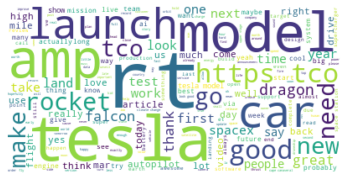

In [59]:

wordcloud = WordCloud(  background_color="white").generate(" ".join(corpus))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [60]:
#Bag of words
#create a vocabulary of words, 
cv=CountVectorizer()
word_count_vector=cv.fit_transform(corpus)
print(word_count_vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [61]:
list(cv.vocabulary_.keys())[:10]

['and',
 'robot',
 'spar',
 'humanity',
 'forin2020',
 'exactly',
 'tesla',
 'absurdly',
 'overvalue',
 'base']

In [62]:

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
 

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [0]:
#d_test=df['text'].tolist()
#d_test

In [63]:

feature_names=cv.get_feature_names()
feature_names

['00',
 '000km',
 '008',
 '01',
 '02',
 '04uqqu0fza',
 '05',
 '06',
 '07',
 '095whwmtkp',
 '095whx44bx',
 '0kgddcvzv0',
 '0lhnzebdqh',
 '0mw11sanwl',
 '0ndqpby3re',
 '0p1hxlw12u',
 '0q3jq1ywjg',
 '10',
 '100',
 '1000',
 '100000',
 '1000lb',
 '1000m',
 '1000th',
 '1001am',
 '100d',
 '100k',
 '100mwh',
 '100s',
 '100t',
 '100th',
 '101',
 '1010',
 '1021am',
 '1027pm',
 '1029am',
 '1032am',
 '105',
 '105f',
 '106',
 '109',
 '10b',
 '10cm',
 '10k',
 '10m',
 '10th',
 '10x',
 '11',
 '110',
 '111',
 '112',
 '1130',
 '115',
 '1187m',
 '11am',
 '11b',
 '11pm',
 '12',
 '120',
 '1200',
 '1202m',
 '121am',
 '122',
 '124000',
 '1245am',
 '1247',
 '126',
 '126am',
 '12m',
 '12v',
 '13',
 '130',
 '130pm',
 '13b',
 '14',
 '140',
 '142pm',
 '145pm',
 '14b',
 '15',
 '150',
 '1500',
 '150000',
 '1501',
 '150km',
 '155',
 '16',
 '160',
 '160km',
 '165',
 '1659',
 '16th',
 '17',
 '170',
 '171m',
 '17775',
 '17m',
 '17th',
 '18',
 '180',
 '1800',
 '180000',
 '18th',
 '19',
 '1927',
 '1941',
 '194cierj',
 '1

In [0]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
 
 

In [65]:
corpus[:2]

['and robot spar humanity',
 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6']

In [66]:
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

In [0]:
for date in df.Date:
  print(date.year)

In [91]:
#Goal : 
'''
-------------------return ---------------------
list_dates = {2017: doc1, doc2... , 2018 : doc5,doc10.........}

'''
list_dates = []
last_year = df.Date[0].year
dict ={}
list_of_same_year = []
for index, row in df.iterrows():
    #print(row['Date'], row['text'])
    year = row['Date'].year
    #print(year)
    # if the same year add it to last key and append , else change key
   
    if last_year == year:
       list_of_same_year.append(row['text'])
       print(list_of_same_year)
       dict[year] = list_of_same_year # {2014: doc , doc}
       print(dict)

    else:
       list_of_same_year = []
       l =list_of_same_year
       l.append(row['text'])
       dict[year] = l
       
#list_dates.append(dict)
#list_dates

dict
    


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{2010: ['please ignore prior tweet someone pretend ) actually'],
 2011: ['go iceland sit ride bumper car ice country s rink van nuys awesome family fun )'],
 2012: ['my first prediction 2012 come true ouch head'],
 2013: ['this give sense mar would look like change climate sustain life'],
 2014: ['prepare launch thaicom satellite geostationary super-sync orbit 5pm florida time'],
 2015: ['rt 2014 includedn6 falcon 9 launch xe2x9cx93ncrew dragon unveiling xe2x9cx93nsoft land 1st stage s revolutionary'],
 2016: ['falcon 9 back hangar cape canaveral damage find ready fire'],
 2017: ['and robot spar humanity',
  'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6',
  'waltmossberg et tu',
  'stormy weather shortville',
  'daveleebbc coal die due nat gas fracking basically',
  'lexxxzis helicopter s',
  'verge',
  'supercoolcube pretty',
  'why waste much time develop silly rocket damn alien obtuse crazy tech t speak',
  'technology breakthrough turn chemtrails actually mes

In [95]:
for year,docs in dict.items():
 
    #generate tf-idf for the given document
    '''for doc in list(docs):
      print(doc)
      break'''
    print(docs)

['and robot spar humanity', 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6', 'waltmossberg et tu', 'stormy weather shortville', 'daveleebbc coal die due nat gas fracking basically', 'lexxxzis helicopter s', 'verge', 'supercoolcube pretty', 'why waste much time develop silly rocket damn alien obtuse crazy tech t speak', 'technology breakthrough turn chemtrails actually message time-traveling alien describe secret', 'rt ve create s first spam-detecting ai train entirely simulation deploy physical robot', 'rt extremely important - reusable rocket bring us much closer become', 'adamsbj def p100d ludicrous+ although rocket start go lot faster', 'badastronomer def bring back like dragon question much weight need', 'teslaaddict work', 'jasonlamb look like could 20% structural upgrade handle high load s fully expendable', 'cheron', 'cardoso silly thing imagine secret payload 1st dragon flight giant wheel cheese inspire bxe2x80xa6', 'redletterdave good point odds go 0% &gt

In [108]:
'''
total_keywords = []

for year,docs in dict.items():
 
    #generate tf-idf for the given document
    keywords_per_year = []
    print('-----------------for year',year,'those are the keywords:-----------------------------')
    for doc in docs:
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
 
        #sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())
 
        #extract only the top n; n here is 10
        #keywords=extract_topn_from_vector(feature_names,sorted_items,1)
        #print(keywords)
      
    #keywords_per_year.append(keywords)
    keywords_per_year=extract_topn_from_vector(feature_names,sorted_items,10)
    print(keywords_per_year)
    total_keywords.append(keywords_per_year)
    

 
print('----------------total keywords for all the years:--------------------------------\n' ,total_keywords)'''

-----------------for year 2017 those are the keywords:-----------------------------
{'vandenberg': 0.38, 'down': 0.38, 'force': 0.326, 'complete': 0.298, 'hold': 0.294, 'air': 0.29, 'fire': 0.277, 'system': 0.273, 'next': 0.231, 'go': 0.222}
-----------------for year 2016 those are the keywords:-----------------------------
{'hangar': 0.419, 'damage': 0.407, 'ready': 0.363, 'find': 0.32, 'canaveral': 0.318, 'cape': 0.309, 'fire': 0.297, 'back': 0.289, 'falcon': 0.237}
-----------------for year 2015 those are the keywords:-----------------------------
{'xe2x9cx93nsoft': 0.368, 'xe2x9cx93ncrew': 0.368, 'includedn6': 0.368, 'revolutionary': 0.35, 'unveiling': 0.319, '2014': 0.301, '1st': 0.257, 'stage': 0.231, 'land': 0.2, 'falcon': 0.191}
-----------------for year 2014 those are the keywords:-----------------------------
{'sync': 0.378, 'geostationary': 0.36, '5pm': 0.346, 'thaicom': 0.336, 'prepare': 0.336, 'florida': 0.328, 'super': 0.261, 'satellite': 0.254, 'orbit': 0.254, 'time': 0.

In [120]:

total_keywords = []
dict1 = {}
years = []
for year,docs in dict.items():
    years.append(year)
    #generate tf-idf for the given document
    keywords_per_year = []
    print('-----------------for year',year,'those are the keywords:-----------------------------')
    for doc in docs:
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
 
        #sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())
 
        #extract only the top n; n here is 10
        #keywords=extract_topn_from_vector(feature_names,sorted_items,1)
        #print(keywords)
      
    #keywords_per_year.append(keywords)
    keywords_per_year=extract_topn_from_vector(feature_names,sorted_items,10)
    print(keywords_per_year)
    dict1[year] = keywords_per_year
    total_keywords.append(dict1)
    

 
print('----------------total keywords for all the years:--------------------------------\n' ,total_keywords)

-----------------for year 2017 those are the keywords:-----------------------------
{'vandenberg': 0.38, 'down': 0.38, 'force': 0.326, 'complete': 0.298, 'hold': 0.294, 'air': 0.29, 'fire': 0.277, 'system': 0.273, 'next': 0.231, 'go': 0.222}
-----------------for year 2016 those are the keywords:-----------------------------
{'hangar': 0.419, 'damage': 0.407, 'ready': 0.363, 'find': 0.32, 'canaveral': 0.318, 'cape': 0.309, 'fire': 0.297, 'back': 0.289, 'falcon': 0.237}
-----------------for year 2015 those are the keywords:-----------------------------
{'xe2x9cx93nsoft': 0.368, 'xe2x9cx93ncrew': 0.368, 'includedn6': 0.368, 'revolutionary': 0.35, 'unveiling': 0.319, '2014': 0.301, '1st': 0.257, 'stage': 0.231, 'land': 0.2, 'falcon': 0.191}
-----------------for year 2014 those are the keywords:-----------------------------
{'sync': 0.378, 'geostationary': 0.36, '5pm': 0.346, 'thaicom': 0.336, 'prepare': 0.336, 'florida': 0.328, 'super': 0.261, 'satellite': 0.254, 'orbit': 0.254, 'time': 0.

In [130]:
for item in years:
  print(type(item))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


# Visualizing keywords using Word Cloud

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


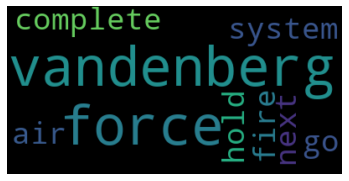

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


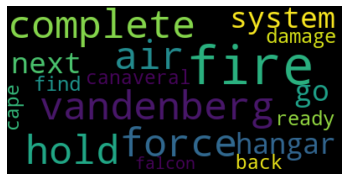

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


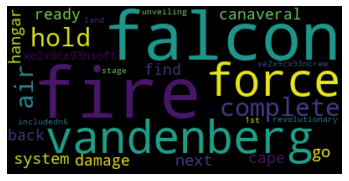

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


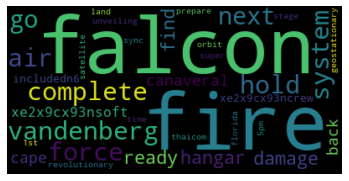

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


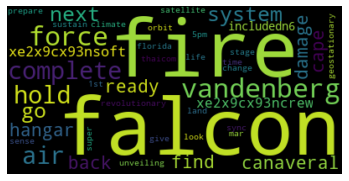

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


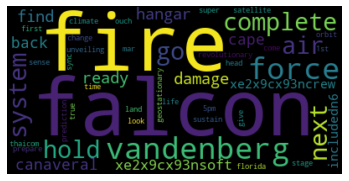

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


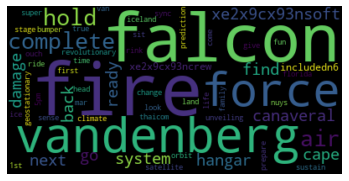

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


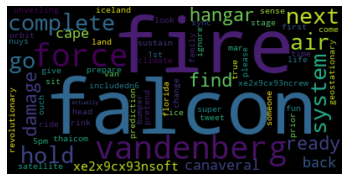

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


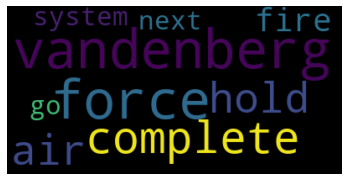

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


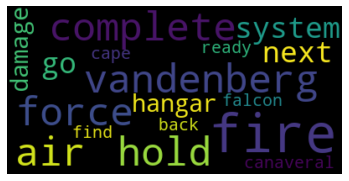

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


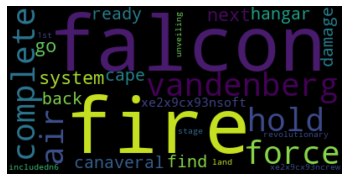

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


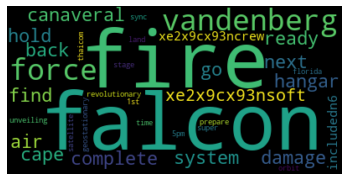

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


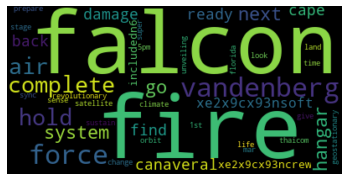

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


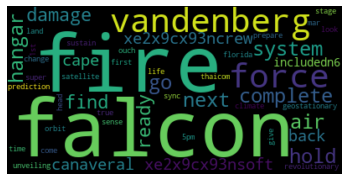

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


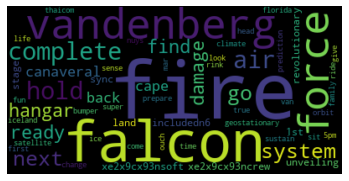

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


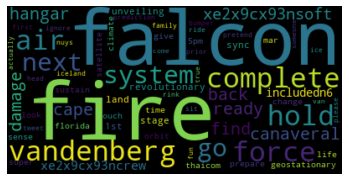

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


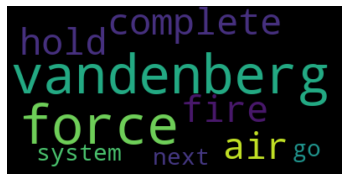

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


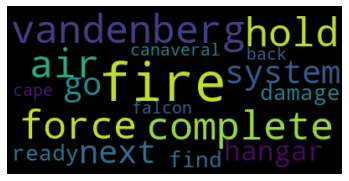

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


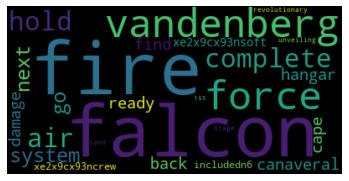

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


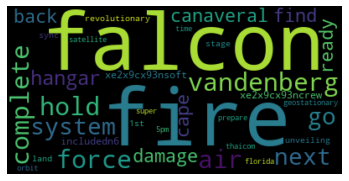

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


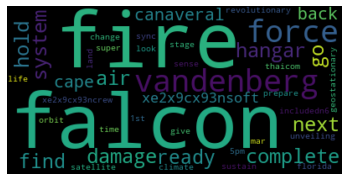

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


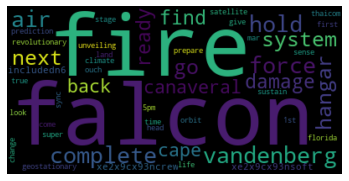

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


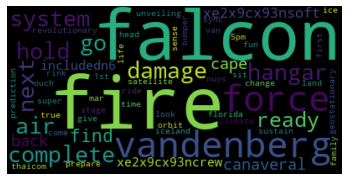

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


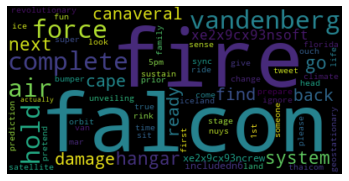

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


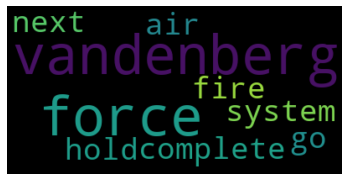

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


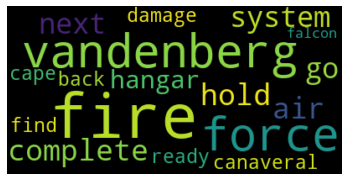

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


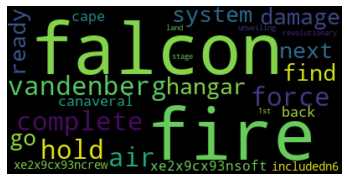

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


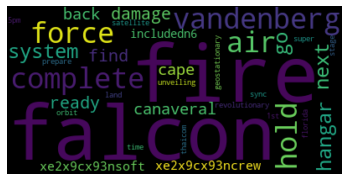

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


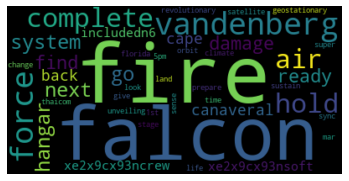

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


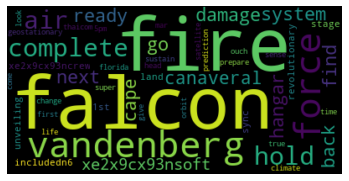

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


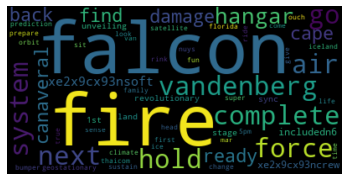

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


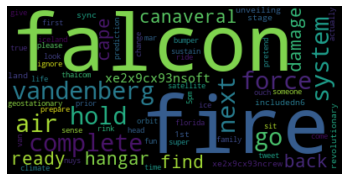

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


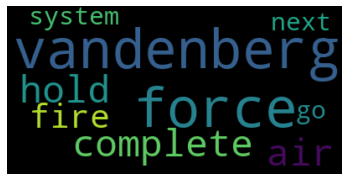

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


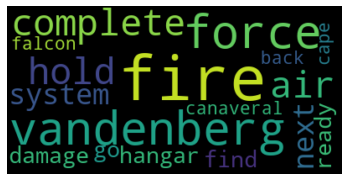

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


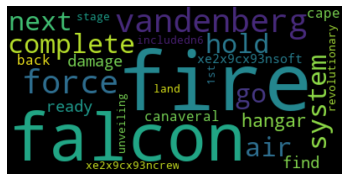

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


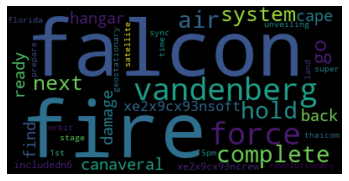

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


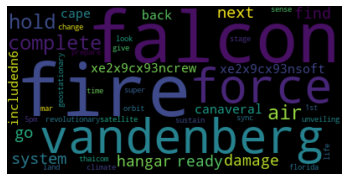

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


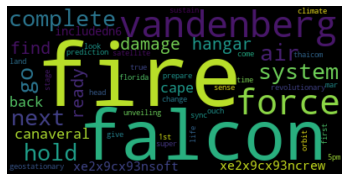

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


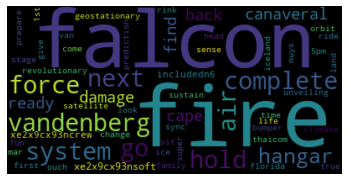

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


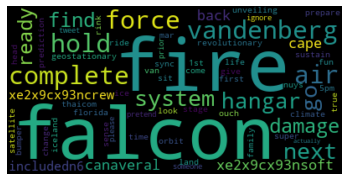

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


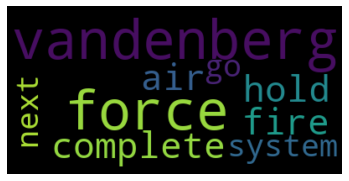

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


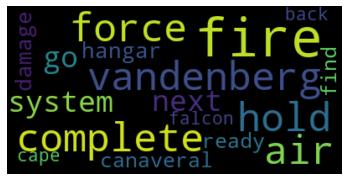

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


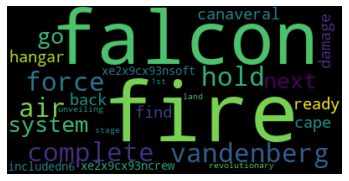

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


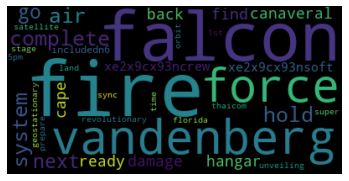

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


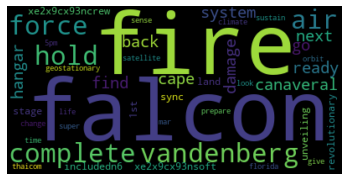

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


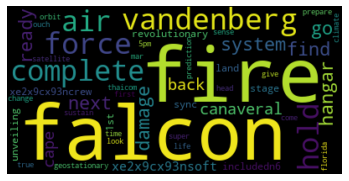

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


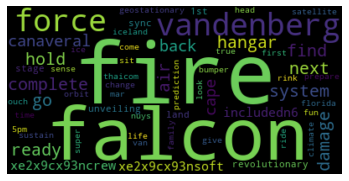

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


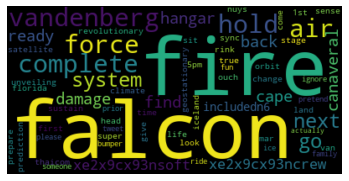

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


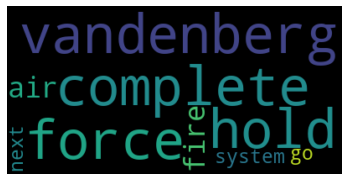

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


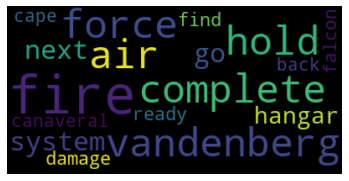

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


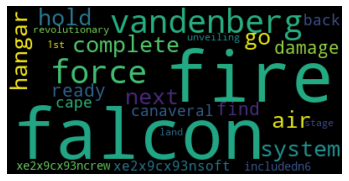

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


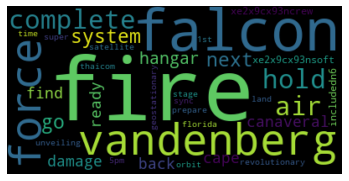

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


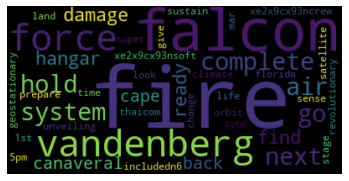

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


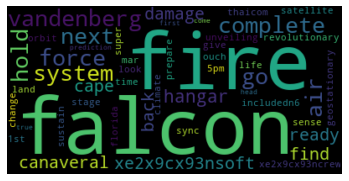

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


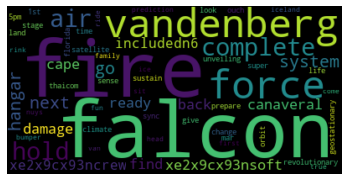

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


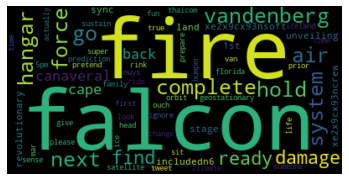

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go


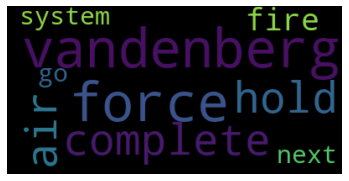

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


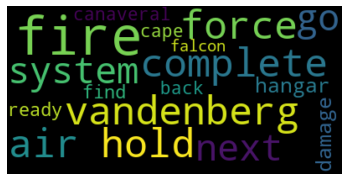

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


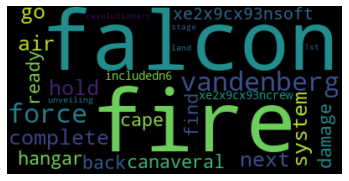

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


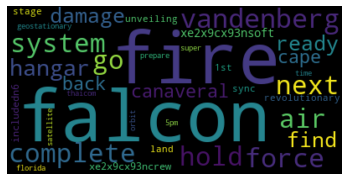

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


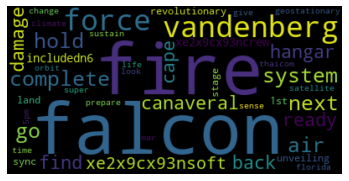

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


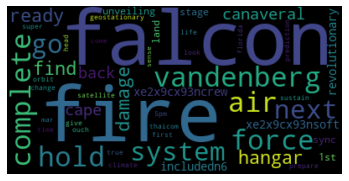

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


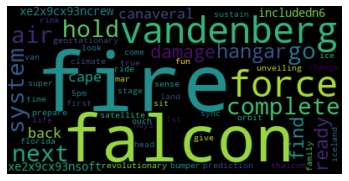

------------------------PLOT WORDCLOUD FOR YEAR/ 2010 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


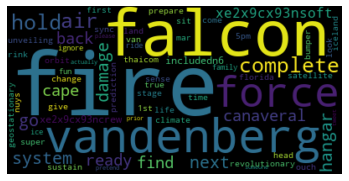

In [118]:
for keywords_year in total_keywords:
  words_list=[]
  for key,value in keywords_year.items():
    print('------------------------PLOT WORDCLOUD FOR YEAR/',year,'----------------------------')
    for word in list(value.keys()):
      words_list.append(word)
    
    words = " ".join(words_list)
    print(words)
    wordcloud = WordCloud().generate(words)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
  

In [119]:
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

## **Plotting the most common words (keywords) % Date **


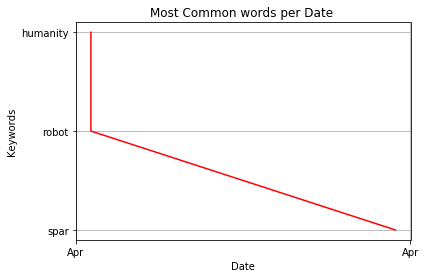

In [0]:

#days, impressions = np.loadtxt("page-impressions.csv", unpack=True,converters={ 0: mdates.strpdate2num('%Y-%m-%d')})
plt.plot_date(x=, y=list(keywords.keys())[:3], fmt="r-")
plt.title("Most Common words per Year")
plt.ylabel("Keywords")
plt.xlabel("Year")
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.grid(True)
plt.show()






# **Making Sequences from words**

In [0]:
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=50)
data

array([[   0,    0,    0, ...,  326, 1413,  413],
       [   0,    0,    0, ...,  876,    5, 2892],
       [   0,    0,    0, ..., 2893,  108, 2894],
       ...,
       [   0,    0,    0, ...,   41,  106, 2761],
       [   0,    0,    0, ...,  123, 1228,  466],
       [   0,    0,    0, ...,  634, 7009,   64]], dtype=int32)

In [0]:
test_data = list(keywords.keys())[:5]

In [0]:
sequ = tokenizer.texts_to_sequences(test_data)
test = pad_sequences(sequ)
test

array([[   0],
       [1413],
       [ 413],
       [ 326]], dtype=int32)

Labels are the most common words :

## Splitting the Dataset

In [0]:


dataset = data[:5]
#random.shuffle(data[:5])

X = data[:5]

X_train , X_test = X[:4],X[4:]
print(X_test)
y= test
y_train , y_test = y[:4],y[4:]
print(y_train)




[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2895  877 1922  101 2896  189 2897  744]]
[[   0]
 [1413]
 [ 413]
 [ 326]]


# **Build a neural network with LSTM**

In [0]:
## Network architecture
model = Sequential()
model.add(Embedding(20000, 100, input_length=50))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
## Fit the model
model.fit(X_train, y_train, epochs=3 , batch_size=10)

Epoch 1/3


InvalidArgumentError: ignored

# **Evaluation **

In [0]:
# evaluate the model
	scores = model.evaluate(X_test, y_test, verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	

In [0]:
model.predict(X_test)